# Homicides in the South

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from GeoConformalizedExplainer import GeoConformalizedExplainer

/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv('../data/south_homicides.csv')

In [21]:
data.head(20)

,fid,primaryindex,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,...,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,lon,lat
0,1,1,Hancock,West Virginia,54,29,54029,54,29,54029,...,0.223645,0.295377,0.332251,0.363934,9.981297,7.8,9.785797,12.604552,-80.578702,40.520355
1,2,2,Brooke,West Virginia,54,9,54009,54,9,54009,...,0.220407,0.318453,0.314165,0.350569,10.929337,8.0,10.214990,11.242293,-80.579875,40.274649
2,3,3,Ohio,West Virginia,54,69,54069,54,69,54069,...,0.272398,0.358454,0.376963,0.390534,15.621643,12.9,14.716681,17.574021,-80.622604,40.099872
3,4,4,Marshall,West Virginia,54,51,54051,54,51,54051,...,0.227647,0.319580,0.320953,0.377346,11.962834,8.8,8.803253,13.564159,-80.666062,39.861063
4,5,5,New Castle,Delaware,10,3,10003,10,3,10003,...,0.256106,0.329678,0.365830,0.332703,12.035714,10.7,15.169480,16.380903,-75.650102,39.584505
5,6,6,Washington,Maryland,24,43,24043,24,43,24043,...,0.257266,0.334819,0.343903,0.344267,12.273212,9.3,10.501908,13.093521,-77.814438,39.603483
6,7,7,Allegany,Maryland,24,1,24001,24,1,24001,...,0.259956,0.335631,0.344512,0.384318,14.503302,11.0,11.739130,15.502258,-78.698318,39.621918
7,8,8,Cecil,Maryland,24,15,24015,24,15,24015,...,0.253666,0.323361,0.328207,0.332786,10.905885,8.4,10.074674,12.651254,-75.941322,39.584736
8,9,9,Garrett,Maryland,24,23,24023,24,23,24023,...,0.339693,0.365432,0.361536,0.371719,12.140380,8.9,9.443270,10.887149,-79.275203,39.528014
9,10,10,Harford,Maryland,24,25,24025,24,25,24025,...,0.256384,0.312853,0.325357,0.318068,9.680950,7.8,10.348491,11.344855,-76.324310,39.567028


In [4]:
homicide_rate = data['HC90']

In [5]:
homicide_rate

0        0.333333
1        0.333333
2        1.333333
3        1.666667
4       29.666667
          ...    
1407     4.333333
1408     1.666667
1409     2.666667
1410     2.333333
1411     9.333333
Name: HC90, Length: 1412, dtype: float64

In [6]:
features = data[['PO90', 'RD90', 'PS90', 'UE90', 'DV90', 'MA90', 'MFIL89', 'FP89', 'BLK90', 'GI89', 'FH90', 'DNL90', 'lon', 'lat']]

In [7]:
loc = data[['lon', 'lat']]

In [8]:
X_train, X_temp, y_train, y_temp, loc_train, loc_temp = train_test_split(features, homicide_rate, loc, train_size=0.8, random_state=42)

In [9]:
X_calib, X_test, y_calib, y_test, loc_calib, loc_test = train_test_split(X_temp, y_temp, loc_temp, train_size=0.5, random_state=42)

In [10]:
model = xgb.XGBRegressor(n_estimators=400, max_depth=3, min_child_weight=0.8, colsample_bytree=0.8, objective='count:poisson')

In [11]:
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=0.8, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [12]:
model.score(X_test, y_test)

0.7968828895965294

In [13]:
explainer = GeoConformalizedExplainer(model, X_train, X_calib, loc_calib.values, loc_test.values, 0.1, 3)

In [15]:
results = explainer.uncertainty_aware_explain(x_test=X_test)

 29%|██▊       | 4/14 [00:20<00:00, 37.34it/s]/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:33] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)
 57%|█████▋    | 8/14 [01:16<01:07, 11.23s/it]/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:34] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [15:00:36] WARNING: /var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/abs_b6qk1lz_ug/croot/xgboost-split_1724073748391/work/src/learner.cc:740: 
Parameters: { "params" 

In [16]:
results.accuracy_summary()

,coverage_probability,R2,RMSE,SHAP_Var,Pred_SHAP_Var
PO90,0.936620,0.996617,0.060861,1.094970,1.078908
RD90,0.922535,0.823900,0.032487,0.005993,0.004164
PS90,0.929577,0.979744,0.033434,0.055185,0.055312
UE90,0.887324,0.757842,0.035062,0.005077,0.003513
DV90,0.887324,0.816425,0.032924,0.005905,0.007327
MA90,0.936620,0.903550,0.030293,0.009515,0.007982
MFIL89,0.915493,0.902549,0.016998,0.002965,0.002686
FP89,0.887324,0.867754,0.036631,0.010147,0.009142
BLK90,0.908451,0.970476,0.028874,0.028239,0.028401
GI89,0.894366,0.880093,0.018624,0.002893,0.002185


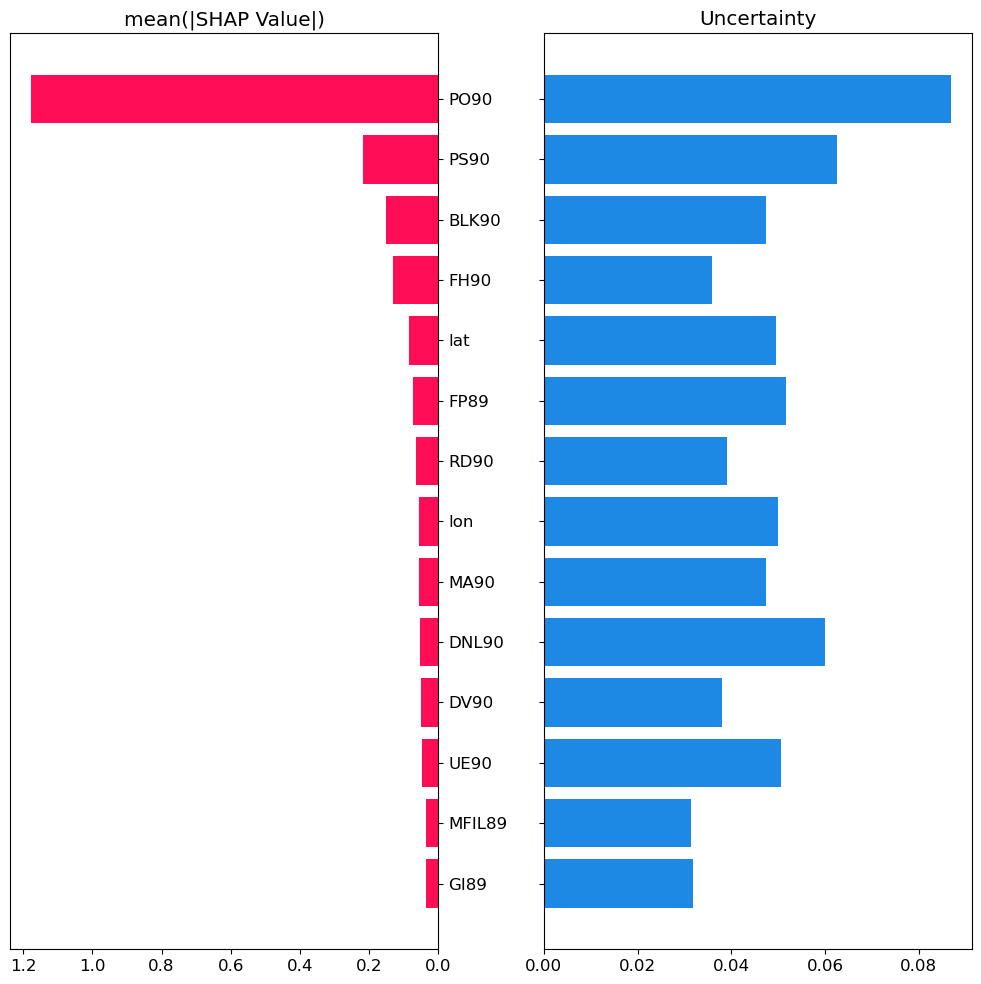

In [17]:
results.plot_absolute_shap_value_with_uncertainty()

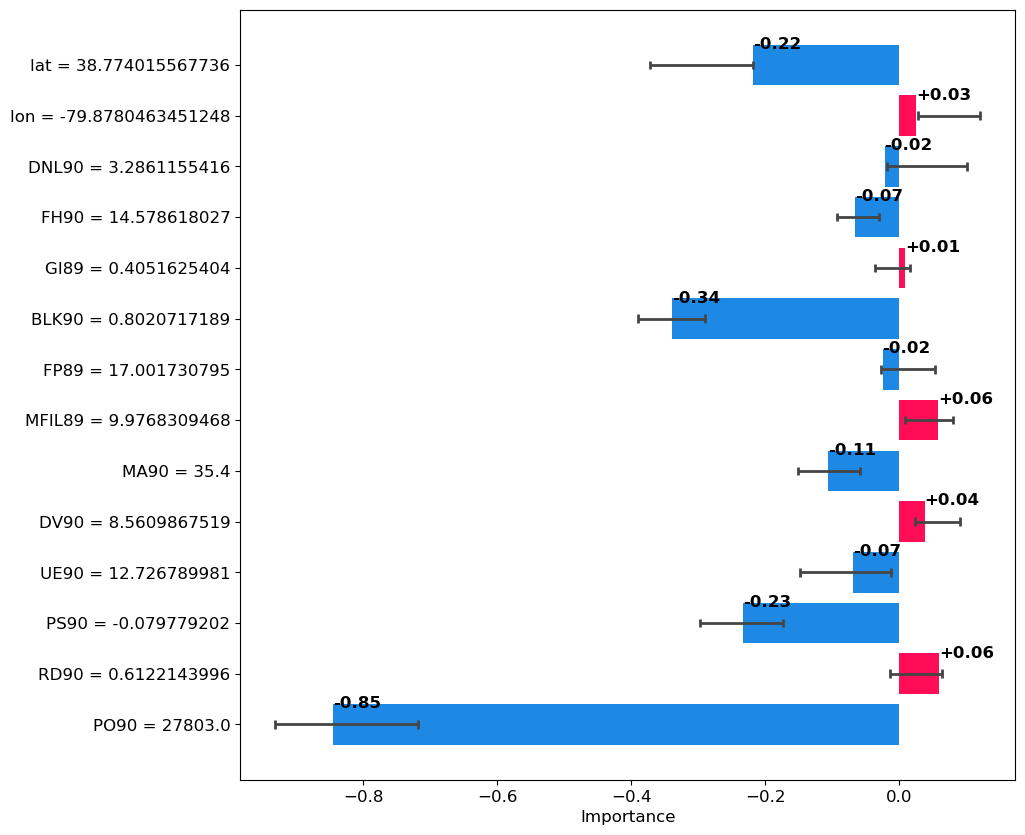

In [18]:
results.plot_shap_values_with_uncertainty(10)

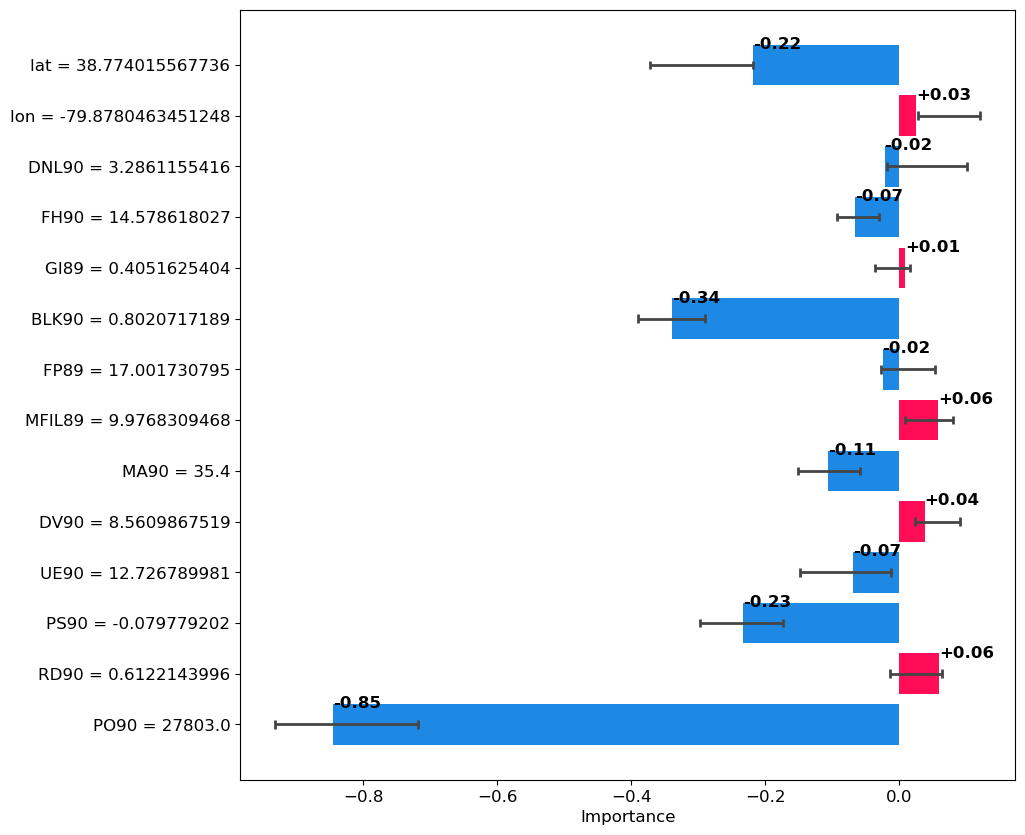

In [19]:
results.plot_shap_values_with_uncertainty(10)

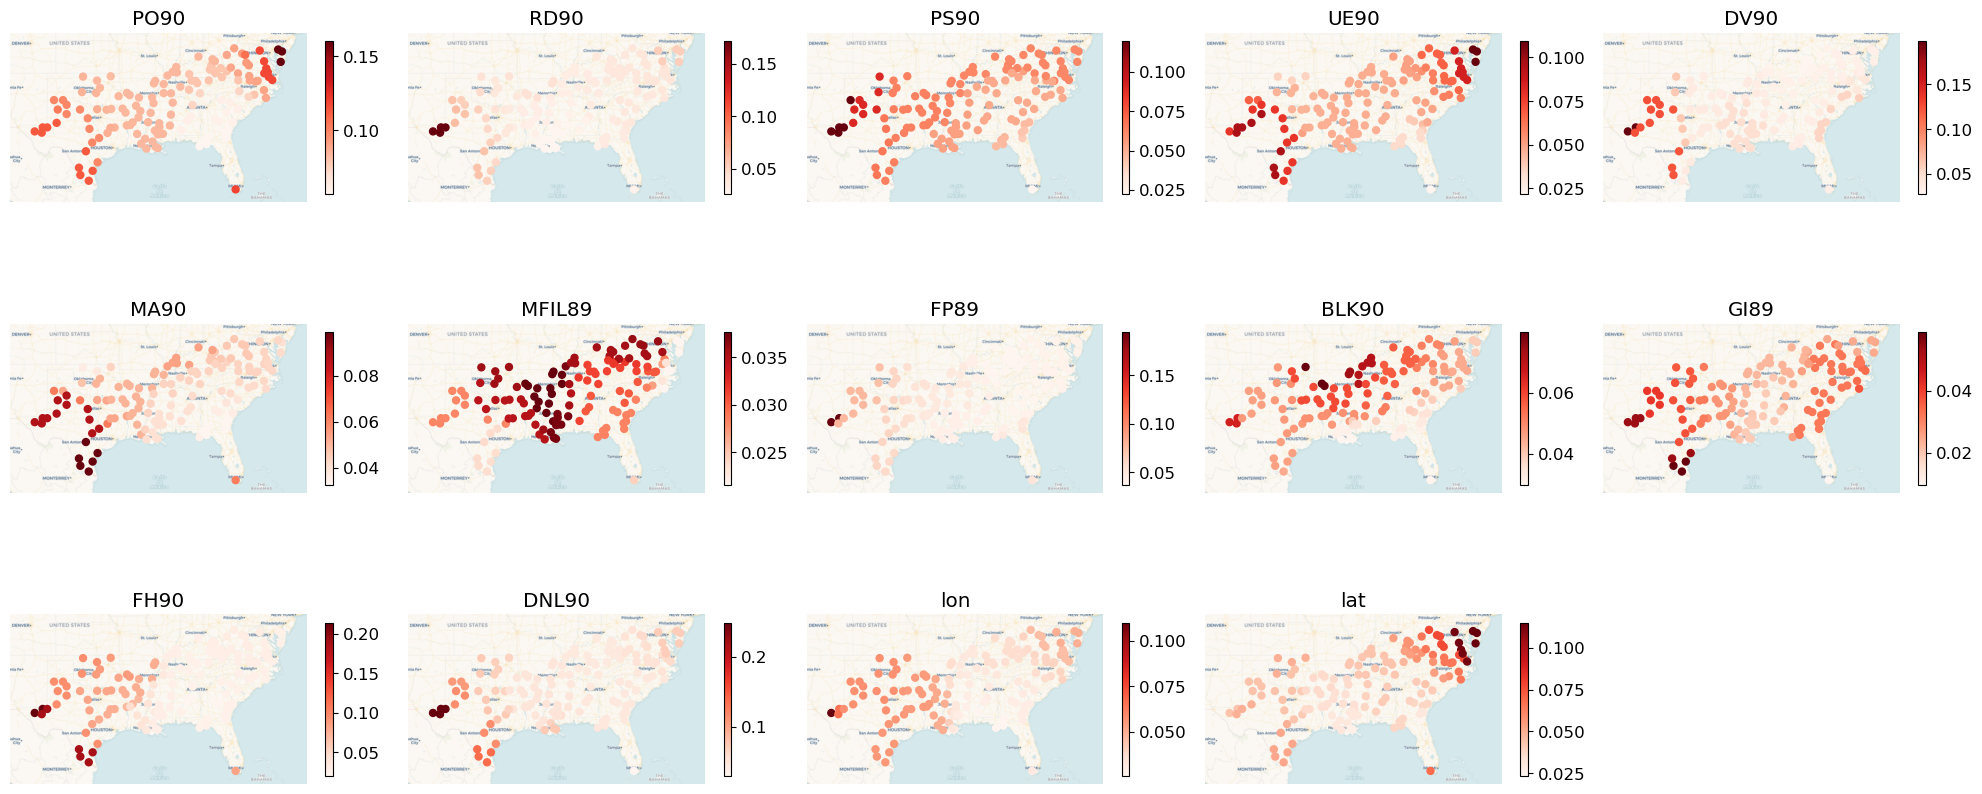

In [20]:
results.plot_geo_uncertainty(figsize=(20, 10), shrink=0.4)

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000

(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)
(141,)

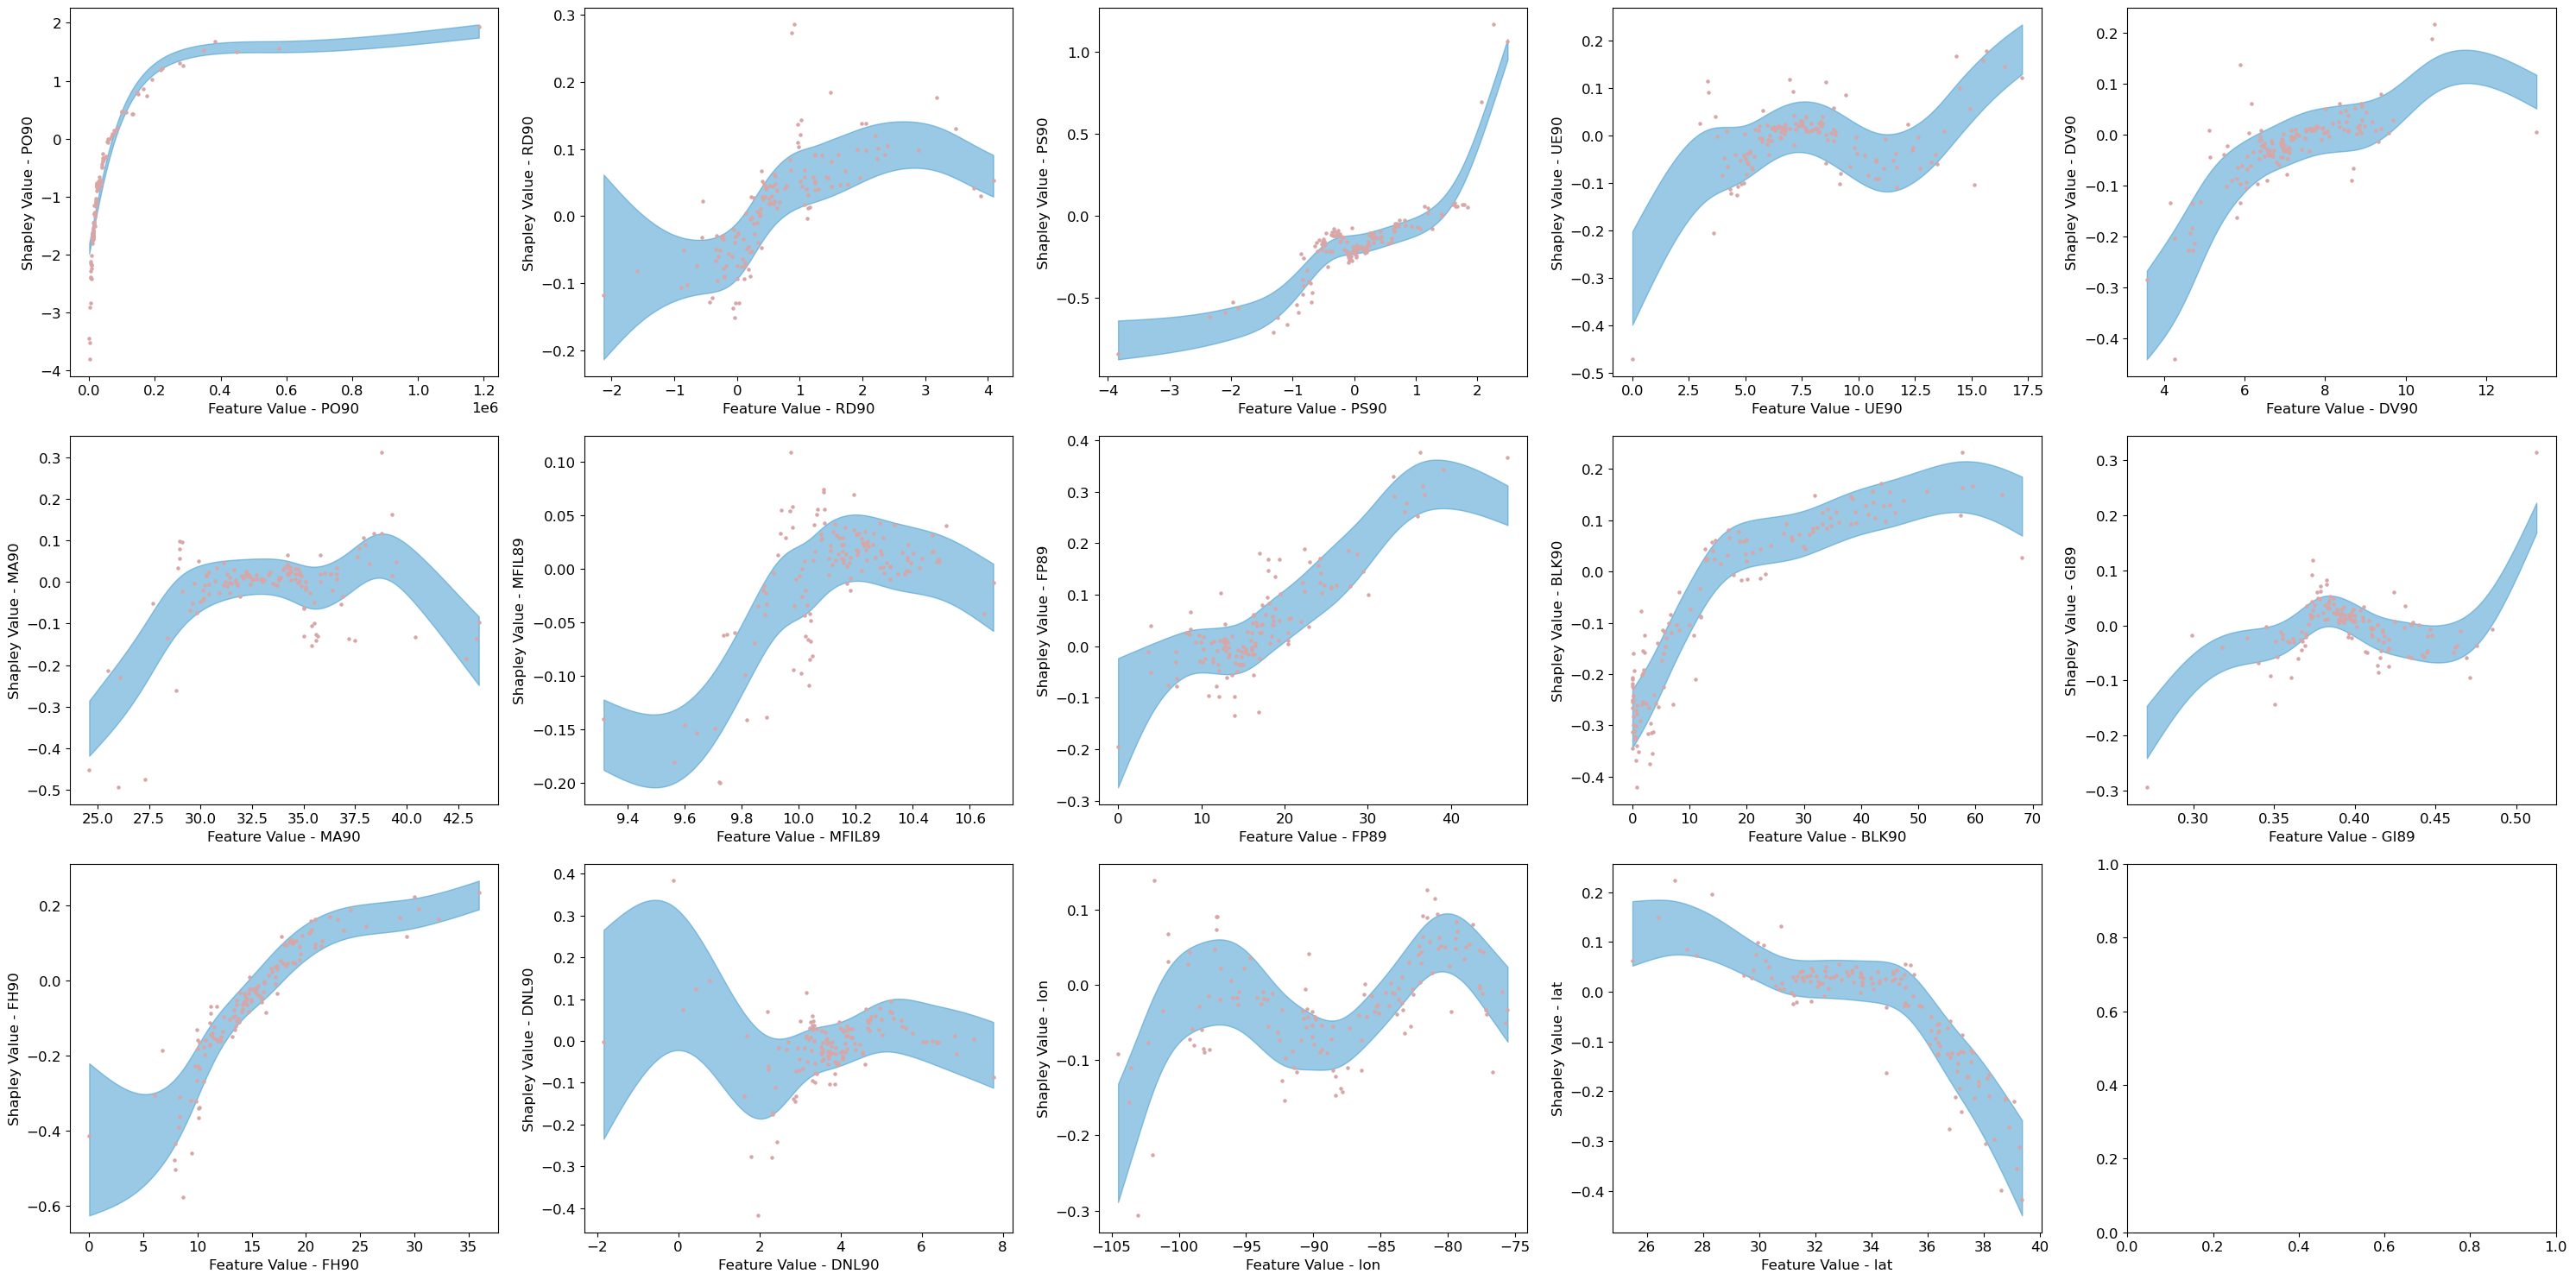

In [22]:
results.plot_partial_dependence_with_fitted_bounds()